## <font color=darkcyan> Кластеризация недвижимости для сдачи в аренду</font>
### План работы:
1. Найти данные для кластеризации. Данные в группе не должны 
повторяться! Внимание, если признаки в данных имеют очень сильно 
разные масштабы, то необходимо данные предварительно 
нормализовать.
2. Провести кластеризацию данных с помощью алгоритма k-means. 
Использовать «правило локтя» и коэффициент силуэта для поиска 
оптимального количества кластеров.
3. Провести кластеризацию данных с помощью алгоритма иерархической 
кластеризации.
4. Провести кластеризацию данных с помощью алгоритма DBSCAN.
5. Сравнить скорость работы алгоритмов. Результаты изобразить в виде 
таблицы.
6. Визуализировать кластеризованные данные с помощью t-SNE или 
UMAP если данные многомерные. Если данные трехмерные, то можно 
использовать трехмерный точечный график.




### Импорт библиотек

In [156]:
import numpy as np
import pandas as pd

from scipy.stats import norm, beta

import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.style as style


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN


from IPython.display import display
%matplotlib inline

In [3]:
home = pd.read_csv('../input/property-data/property.csv')
print(home.shape)
home.head()

(4930, 11)


,item_id,deposit,monthly_rent,district_uuid,room_qty,unit_area,has_elevator,building_floor_count,unit_floor,has_storage_area,property_age
0,91c0e569-bddd-4128-9720-2550bb85580e,64800000.0,0,263682f6-d0cd-4569-aeec-e727b76b7665,1.0,42,False,3.0,0.0,True,23.0
1,b00b7919-06be-4d26-98b8-1971787e1d46,72000000.0,4320000,97c9535e-3985-47ce-a84c-a962c838a76b,2.0,116,True,NaN,1.0,True,16.0
2,9eddb6bc-e424-4774-b55f-bfd54366d627,50400000.0,1440000,b790f536-c274-4147-86e0-94d9b6d7352d,1.0,74,False,2.0,0.0,True,19.0
3,12cf6b07-5d56-4126-94d2-ce9cbfe2214f,36000000.0,864000,93d06676-4975-4cc5-919b-3a0c29c7ad43,1.0,60,True,NaN,2.0,False,6.0
4,929eb20c-3694-46b2-b96c-91117b995d1b,28800000.0,1296000,58e59fa9-9947-478f-9cef-bc6a2cbe49a9,1.0,45,True,NaN,1.0,True,4.0


### Описание данных
- **item_id** - ID объекта;
- **deposit** - залог;
- **monthly_rent** - стоимость помесячной аренды;
- **district_uuid** - ID района;
- **room_qty** - класс жилья?..;
- **unit_area** - общая площадь;
- **has_elevator** - наличие лифта;
- **building_floor_count** - количество этажей в доме;
- **unit_floor** - этаж;
- **has_storage_area** - наличие складского помещения;
- **property_age** - возраст недвижимости.

In [4]:
home.duplicated().any()

False

deposit                    5
district_uuid              1
room_qty                   3
has_elevator              17
building_floor_count    1648
unit_floor                37
has_storage_area          10
property_age               4
dtype: int64

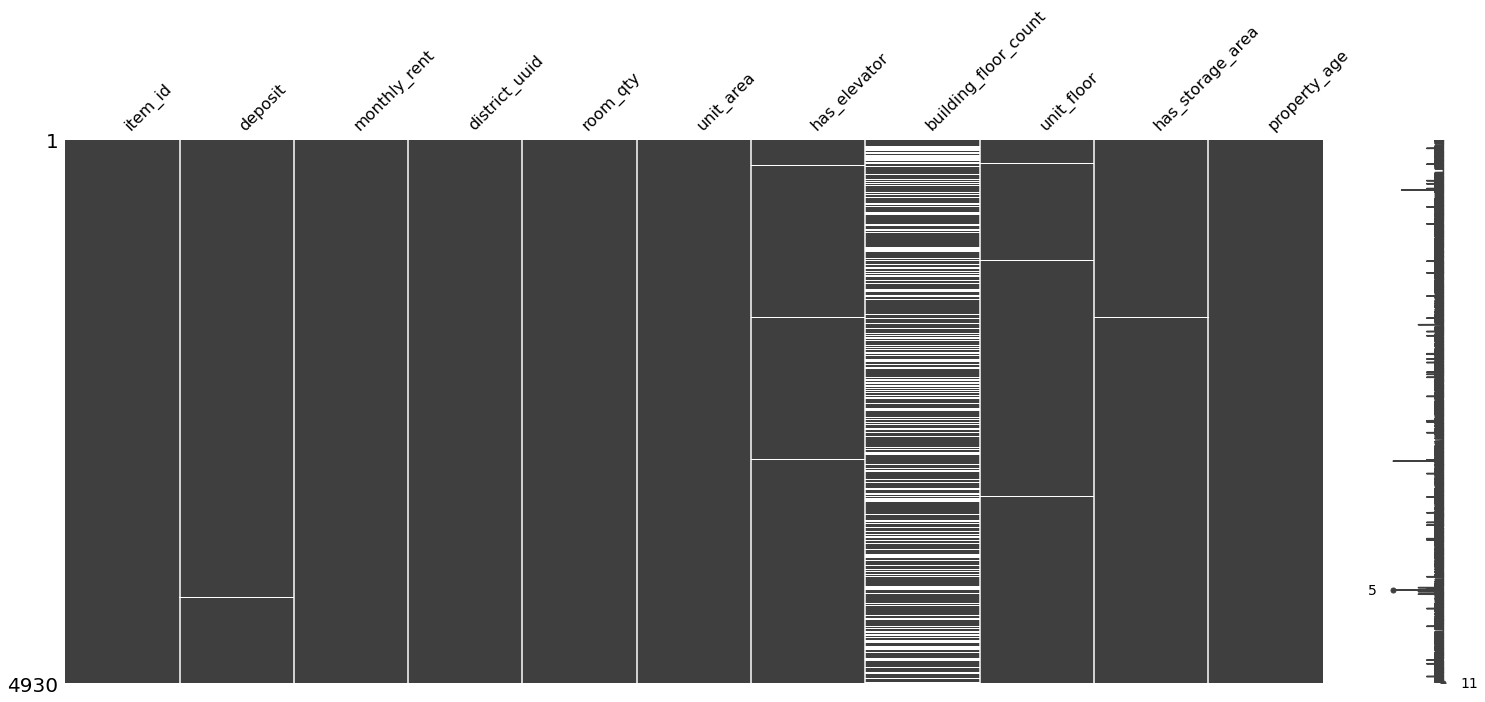

In [5]:
missing = home.isnull().sum()
missing = missing[missing > 0]
display(missing)

msno.matrix(home);

In [6]:
home.dtypes

item_id                  object
deposit                 float64
monthly_rent              int64
district_uuid            object
room_qty                float64
unit_area                 int64
has_elevator             object
building_floor_count    float64
unit_floor              float64
has_storage_area         object
property_age            float64
dtype: object

In [7]:
home.columns[0]

'item_id'

In [8]:
for col in home.columns:
    if col != 'item_id' and col != 'district_uuid':
        print(f'Колонка: {col}')
        print(f'Мода: {round(float(home[col].mode()), 3)}')
        print(f'Медиана: {round(home[col].median(), 3)}')
        print('---------')

Колонка: deposit
Мода: 72000000.0
Медиана: 72000000.0
---------
Колонка: monthly_rent
Мода: 0.0
Медиана: 720000.0
---------
Колонка: room_qty
Мода: 1.0
Медиана: 1.0
---------
Колонка: unit_area
Мода: 63.0
Медиана: 67.0
---------
Колонка: has_elevator
Мода: 0.0
Медиана: 0.0
---------
Колонка: building_floor_count
Мода: 4.0
Медиана: 4.0
---------
Колонка: unit_floor
Мода: 2.0
Медиана: 2.0
---------
Колонка: has_storage_area
Мода: 1.0
Медиана: 1.0
---------
Колонка: property_age
Мода: 15.0
Медиана: 14.0
---------


**MONTHLY_RENT**

In [9]:
home.monthly_rent.value_counts()

0           1846
1440000      382
1080000      305
2160000      243
1800000      220
            ... 
93600000       1
3456000        1
3312000        1
2628000        1
27360000       1
Name: monthly_rent, Length: 98, dtype: int64

In [10]:
monthly_rent_median = home.loc[home.monthly_rent != 0]['monthly_rent'].median()
monthly_rent_median

1440000.0

In [11]:
home.monthly_rent = home.monthly_rent.apply(lambda x: monthly_rent_median if x == 0 else x)
home.monthly_rent.value_counts()

1440000.0     2228
1080000.0      305
2160000.0      243
1800000.0      220
720000.0       201
              ... 
3744000.0        1
72000000.0       1
3312000.0        1
27360000.0       1
2196000.0        1
Name: monthly_rent, Length: 97, dtype: int64

**DEPOSIT, UNIT_AREA, UNIT_FLOOR, BUILDING_FLOOR_COUNT**

In [12]:
# medians = df_mpg_filtered.groupby('Manufacturer').median().reset_index()
# q25 = df_mpg_filtered.groupby('Manufacturer').quantile(0.25).reset_index()
# q75 = df_mpg_filtered.groupby('Manufacturer').quantile(0.75).reset_index()

# sns.swarmplot(x='Manufacturer', y='Combined MPG', data=medians, order=ordered,
#               color='white', edgecolor='black', linewidth=1, size=8)

# sns.swarmplot(x='Manufacturer', y='Combined MPG', data=q25, order=ordered,
#               color='red', edgecolor='black', linewidth=1, size=6)

# sns.swarmplot(x='Manufacturer', y='Combined MPG', data=q75, order=ordered,
#               color='red', edgecolor='black', linewidth=1, size=6)

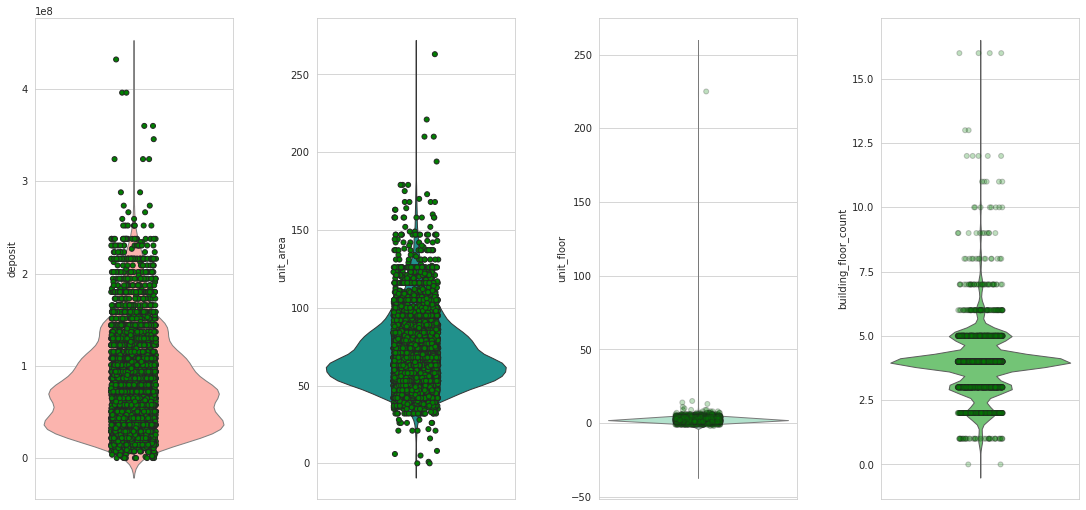

In [13]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,8))
color='green'

plt.subplot(1, 4, 1)
sns.violinplot(home.deposit, inner=None, linewidth=1, palette='Pastel1',
               saturation=1, orient='v', bw=0.2)
sns.stripplot(home.deposit, color=color, jitter=True, linewidth=1, orient='v');

plt.subplot(1, 4, 2)
sns.violinplot(home.unit_area, inner=None, linewidth=1, palette="viridis",
               saturation=1, orient='v', bw=0.2)
sns.stripplot(home.unit_area, color=color, jitter=True, linewidth=1, orient='v');

plt.subplot(1, 4, 3)
sns.violinplot(home.unit_floor, inner=None, linewidth=1, palette='Pastel2',
               saturation=1, orient='v', bw=0.2, cut=50)
sns.stripplot(home.unit_floor, color=color, jitter=True, linewidth=1, orient='v', alpha=0.25);

plt.subplot(1, 4, 4)
sns.violinplot(home.building_floor_count, inner=None, linewidth=1, palette="Greens",
               saturation=1, orient='v', bw=0.2)
sns.stripplot(home.building_floor_count, color=color, jitter=True, linewidth=1, orient='v', alpha=0.25);

fig.tight_layout(pad=4.0)
plt.show();

 Исходя из полученного графика распределения величин, можно составить следующую таблицу:
 
        Нули в колонках:             | Чем заполнить:
        _____________________________________________
        deposit                    5 | mode
        district_uuid              1 | mode
        room_qty                   3 | mode
        has_elevator              17 | mode
        building_floor_count    1648 | mean
        unit_floor                37 | mode
        has_storage_area          10 | mode
        property_age               4 | mean

In [14]:
cols = ['deposit', 'district_uuid', 'room_qty', 'has_elevator',
        'building_floor_count', 'unit_floor', 'has_storage_area', 'property_age']

home[cols]=home.filter(cols).fillna(home.mode().iloc[0])
home.isna().sum()

item_id                 0
deposit                 0
monthly_rent            0
district_uuid           0
room_qty                0
unit_area               0
has_elevator            0
building_floor_count    0
unit_floor              0
has_storage_area        0
property_age            0
dtype: int64

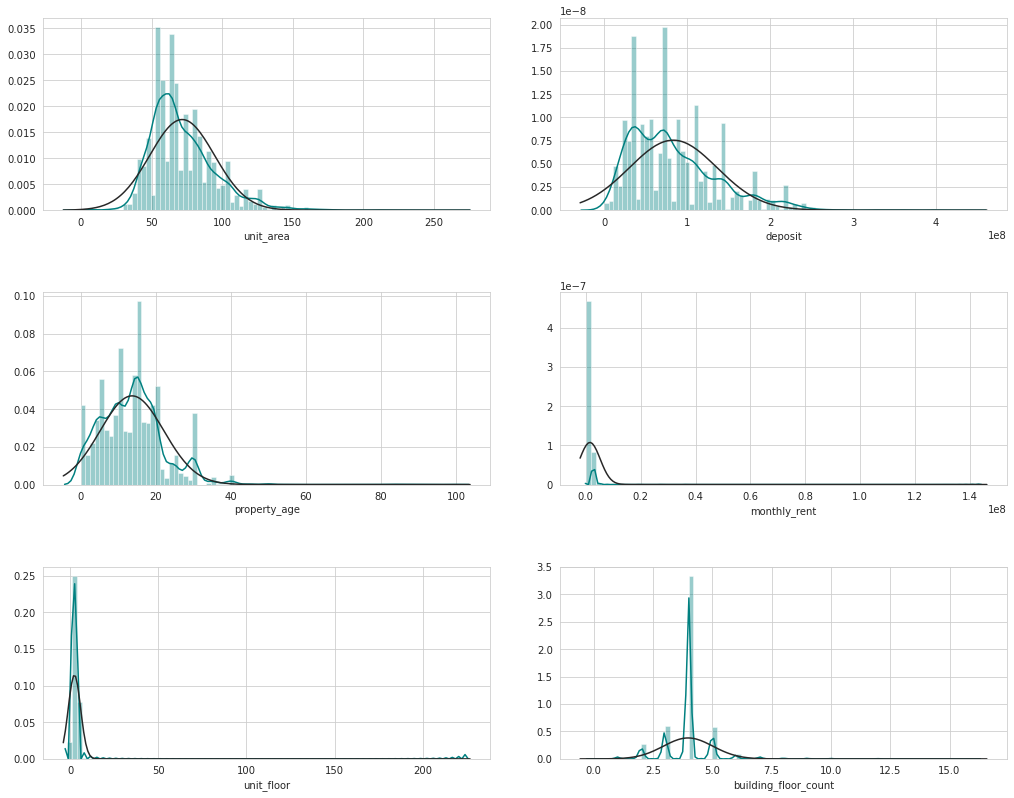

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

plt.subplot(3, 2, 1)
sns.distplot(home['unit_area'], bins=80, kde=True, hist=True, fit=norm, color='teal');

plt.subplot(3, 2, 2)
sns.distplot(home['deposit'] , bins=80, kde=True, hist=True, fit=norm, color = 'teal');

plt.subplot(3, 2, 3)
sns.distplot(home['property_age'] , bins=80, kde=True, hist=True, fit=norm, color = 'teal');

plt.subplot(3, 2, 4)
sns.distplot(home['monthly_rent'] , bins=80, kde=True, hist=True, fit=norm, color = 'teal');

plt.subplot(3, 2, 5)
sns.distplot(home['unit_floor'] , bins=80, kde=True, hist=True, fit=norm, color = 'teal');

plt.subplot(3, 2, 6)
sns.distplot(home['building_floor_count'] , bins=80, kde=True, hist=True, fit=norm, kde_kws={'bw': 0.1}, color = 'teal');

fig.tight_layout(pad=4.0)
plt.show();

In [16]:
home.describe()

,deposit,monthly_rent,room_qty,unit_area,building_floor_count,unit_floor,property_age
count,4.930000e+03,4.930000e+03,4930.000000,4930.000000,4930.000000,4930.000000,4930.000000
mean,8.320146e+07,1.591238e+06,1.471602,71.653347,3.980527,2.413996,13.652130
std,5.287377e+07,3.710691e+06,0.579372,22.890889,1.044955,3.483260,8.480575
min,0.000000e+00,3.600000e+04,0.000000,0.000000,0.000000,-2.000000,0.000000
25%,4.320000e+07,1.152000e+06,1.000000,55.000000,4.000000,1.000000,8.000000
50%,7.200000e+07,1.440000e+06,1.000000,67.000000,4.000000,2.000000,14.000000
75%,1.080000e+08,1.440000e+06,2.000000,84.000000,4.000000,3.000000,18.000000
max,4.320000e+08,1.440000e+08,5.000000,263.000000,16.000000,225.000000,99.000000


Удаляем шум

In [17]:
# Q1 = home.quantile(0.1)
# Q3 = home.quantile(0.9)
# IQR = Q3 - Q1

# home = home[~((home < (Q1 - 1.5 * IQR)) |(home > (Q3 + 1.5 * IQR))).any(axis=1)]
# home.shape

In [18]:
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

# plt.subplot(3, 2, 1)
# sns.distplot(home['unit_area'], bins=80, kde=True, hist=True, fit=norm, color='teal');

# plt.subplot(3, 2, 2)
# sns.distplot(home['deposit'] , bins=80, kde=True, hist=True, fit=norm, color = 'teal');

# plt.subplot(3, 2, 3)
# sns.distplot(home['property_age'] , bins=80, kde=True, hist=True, fit=norm, color = 'teal');

# plt.subplot(3, 2, 4)
# sns.distplot(home['monthly_rent'] , bins=80, kde=True, hist=True, fit=norm, color = 'teal');

# plt.subplot(3, 2, 5)
# sns.distplot(home['unit_floor'] , bins=80, kde=True, hist=True, fit=norm, color = 'teal');

# plt.subplot(3, 2, 6)
# sns.distplot(home['building_floor_count'] , bins=80, kde=True, hist=True, fit=norm, kde_kws={'bw': 0.1}, color = 'teal');

# fig.tight_layout(pad=4.0)
# plt.show();

In [19]:
cats = ['district_uuid', 'has_elevator', 'has_storage_area']
for c in cats:
    le = LabelEncoder()
    home[c] = le.fit_transform(home[c].astype('str'))

In [20]:
home_orig = home.copy()
home.drop('item_id', axis=1, inplace=True)

In [21]:
rb = StandardScaler()
columns = home.columns
home = rb.fit_transform(home)
home = pd.DataFrame(home, columns=columns)
home.head()

,deposit,monthly_rent,district_uuid,room_qty,unit_area,has_elevator,building_floor_count,unit_floor,has_storage_area,property_age
0,-0.348062,-0.040762,-1.325032,-0.814072,-1.295553,-0.733636,-0.938439,-0.693098,0.728083,1.102380
1,-0.211874,0.735453,0.204500,0.912111,1.937502,1.363074,0.018637,-0.405982,0.728083,0.276881
2,-0.620436,-0.040762,0.496911,-0.814072,0.102525,-0.733636,-1.895515,-0.693098,0.728083,0.630666
3,-0.892810,-0.196004,0.159514,-0.814072,-0.509134,1.363074,0.018637,-0.118865,-1.373469,-0.902404
4,-1.028998,-0.079572,-0.425307,-0.814072,-1.164483,1.363074,0.018637,-0.405982,0.728083,-1.138261


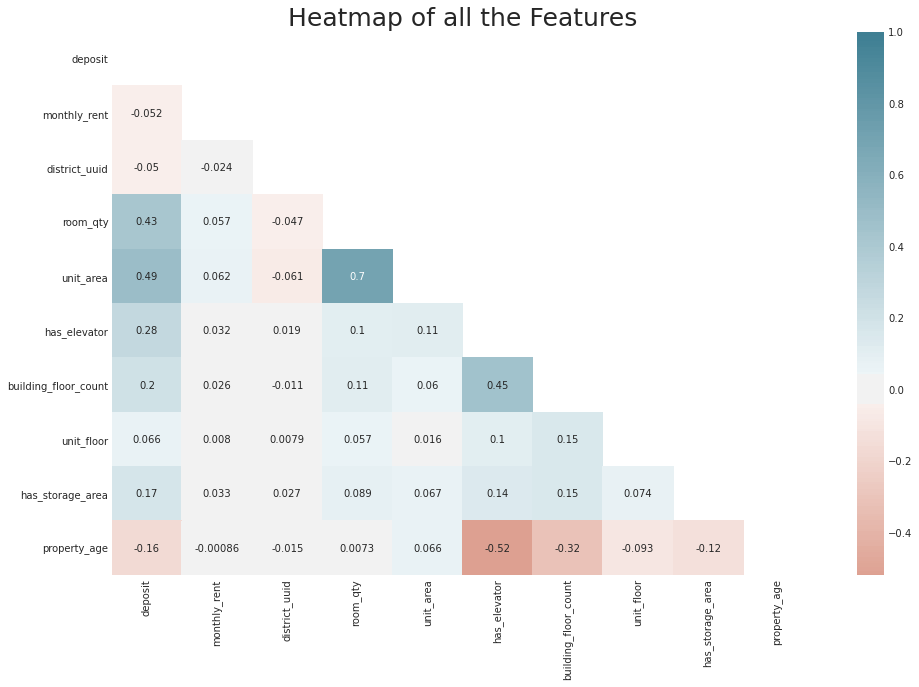

In [155]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (14,10))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(home.loc[:, home.columns.isin(['Cluster_Km', 'ClusterDBSCAN']) == False].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(home.loc[:, home.columns.isin(['Cluster_Km', 'ClusterDBSCAN']) == False].corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 25);


>## <font color=darkcyan> KMeans (с предварительным сжатием пространства)</font>


In [22]:
pca = PCA(n_components=4).fit(home)
pca_samples = pca.transform(home)
pca.fit(home)

#cumulative explaned variance
print (np.cumsum(pca.explained_variance_ratio_))

home_pca = pca.transform(home)

[0.2417127  0.41558333 0.51819728 0.61870928]


In [63]:
# значения коэффициента силуэта
sil_scores = []
# значения функции стоимости
sil_lost_func = []
random_state = 246
start_cluster = 25
end_cluster = 5

for i in range(start_cluster, end_cluster, -1):
    clusterer = KMeans(i, random_state=random_state).fit(home_pca)
    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(home_pca)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    # sample_preds = clusterer.predict(home)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(home_pca, preds)
    sil_scores.append(score)
    sil_lost_func.append(clusterer.inertia_)
    print(i, 'кластеров:', score.round(5))

print(f"Максимальный результат: {max(sil_scores)}, число кластеров: {25 - sil_scores.index(max(sil_scores))}")

25 кластеров: 0.24541
24 кластеров: 0.24595
23 кластеров: 0.23919
22 кластеров: 0.24063
21 кластеров: 0.24675
20 кластеров: 0.2481
19 кластеров: 0.25328
18 кластеров: 0.25965
17 кластеров: 0.26333
16 кластеров: 0.26006
15 кластеров: 0.27072
14 кластеров: 0.26666
13 кластеров: 0.26552
12 кластеров: 0.26927
11 кластеров: 0.25942
10 кластеров: 0.27128
9 кластеров: 0.26795
8 кластеров: 0.26248
7 кластеров: 0.27014
6 кластеров: 0.26757
Максимальный результат: 0.2712782705662998, число кластеров: 10


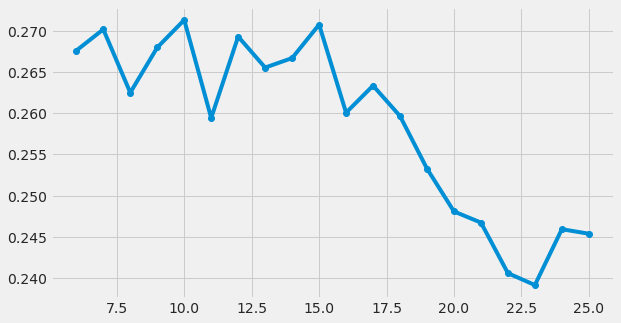

In [64]:
plt.figure(figsize=(9, 5))
plt.style.use("fivethirtyeight")
_ = plt.plot(np.arange(start_cluster, end_cluster, -1), sil_scores, '-o')

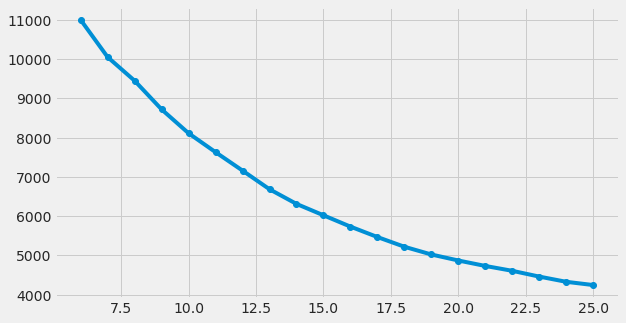

In [65]:
plt.figure(figsize=(9, 5))
plt.style.use("fivethirtyeight")
plt.plot(np.arange(start_cluster, end_cluster, -1), sil_lost_func, marker='o')
plt.show()

In [105]:
km = KMeans(init='k-means++', n_clusters=10, verbose=0, n_init=1, random_state=236)
km.fit(home_pca)
l = km.labels_
print("LABLES")
print(l)

LABLES
[1 0 7 ... 3 2 0]


In [106]:
home_orig['Cluster_Km'] = list(pd.Series(l))
home_orig.head(5)

,item_id,deposit,monthly_rent,district_uuid,room_qty,unit_area,has_elevator,building_floor_count,unit_floor,has_storage_area,property_age,Cluster_Km
0,91c0e569-bddd-4128-9720-2550bb85580e,64800000.0,1440000.0,35,1.0,42,0,3.0,0.0,1,23.0,1
1,b00b7919-06be-4d26-98b8-1971787e1d46,72000000.0,4320000.0,103,2.0,116,1,4.0,1.0,1,16.0,0
2,9eddb6bc-e424-4774-b55f-bfd54366d627,50400000.0,1440000.0,116,1.0,74,0,2.0,0.0,1,19.0,7
3,12cf6b07-5d56-4126-94d2-ce9cbfe2214f,36000000.0,864000.0,101,1.0,60,1,4.0,2.0,0,6.0,4
4,929eb20c-3694-46b2-b96c-91117b995d1b,28800000.0,1296000.0,75,1.0,45,1,4.0,1.0,1,4.0,4


In [107]:
cCs = home_orig.groupby('Cluster_Km')['item_id'].count()
cCs

Cluster_Km
0    643
1    853
2    731
3    813
4    696
5      5
6    526
7    350
8      2
9    311
Name: item_id, dtype: int64

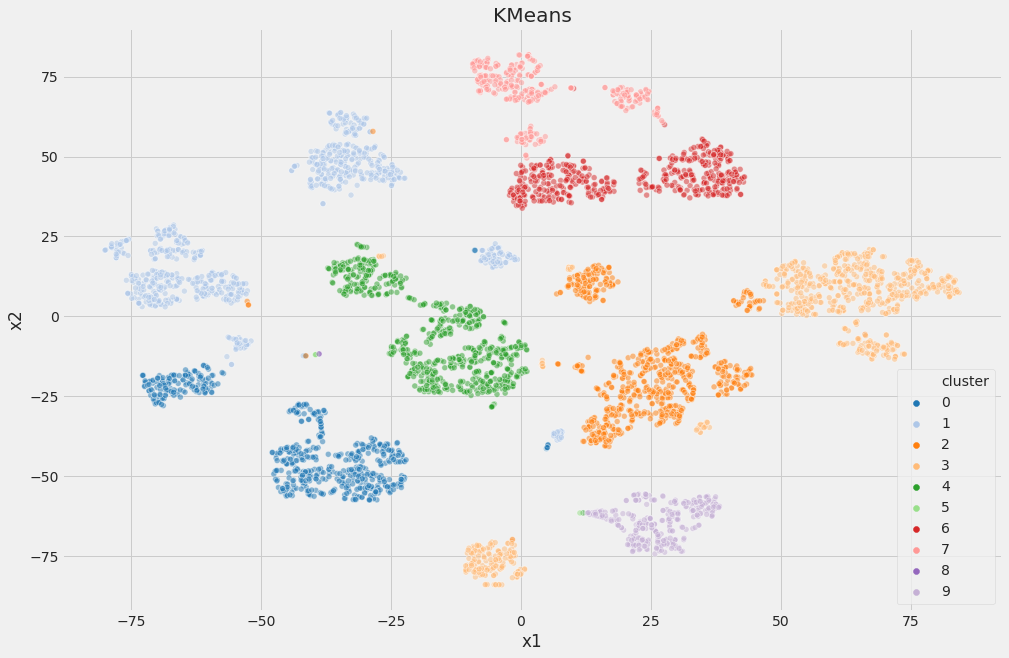

In [109]:
X = home.copy()
Xtsne = TSNE(n_components=2).fit_transform(X)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = km.labels_
dftsne.columns = ['x1','x2','cluster']
plt.figure(figsize=(15,10))
plt.title('KMeans')
sns.scatterplot(data=dftsne, x='x1', y='x2', hue='cluster', legend="full", alpha=0.5, palette='tab20');

In [ ]:
del X


>## <font color=teal> Иерархическая агломеративная кластеризация</font>


In [180]:
aggl_clustering = AgglomerativeClustering(n_clusters=7, linkage='ward').fit(home)
aggl_clustering.labels_

array([5, 2, 0, ..., 5, 1, 1])

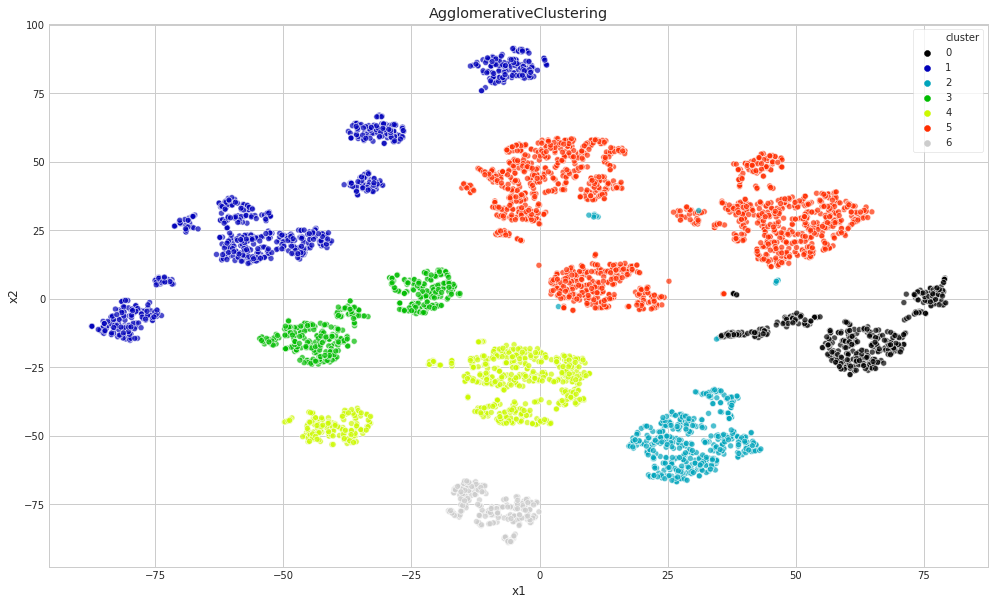

In [182]:
X = home.copy()
Xtsne = TSNE(n_components=2).fit_transform(X)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = aggl_clustering.labels_
dftsne.columns = ['x1','x2','cluster']

fig = plt.figure(figsize=(15,10))
plt.title('AgglomerativeClustering')
sns.scatterplot(data=dftsne, x='x1', y='x2', hue='cluster',
                legend="full", alpha=0.7, palette="nipy_spectral");

>## <font color=teal> DBSCAN</font>


In [141]:
clustering = DBSCAN(eps=2, min_samples=8).fit(home)
clustering.labels_

array([0, 1, 2, ..., 0, 6, 5])

In [142]:
home['ClusterDBSCAN'] = pd.Series(clustering.labels_)
print(home.ClusterDBSCAN.unique().size)

11


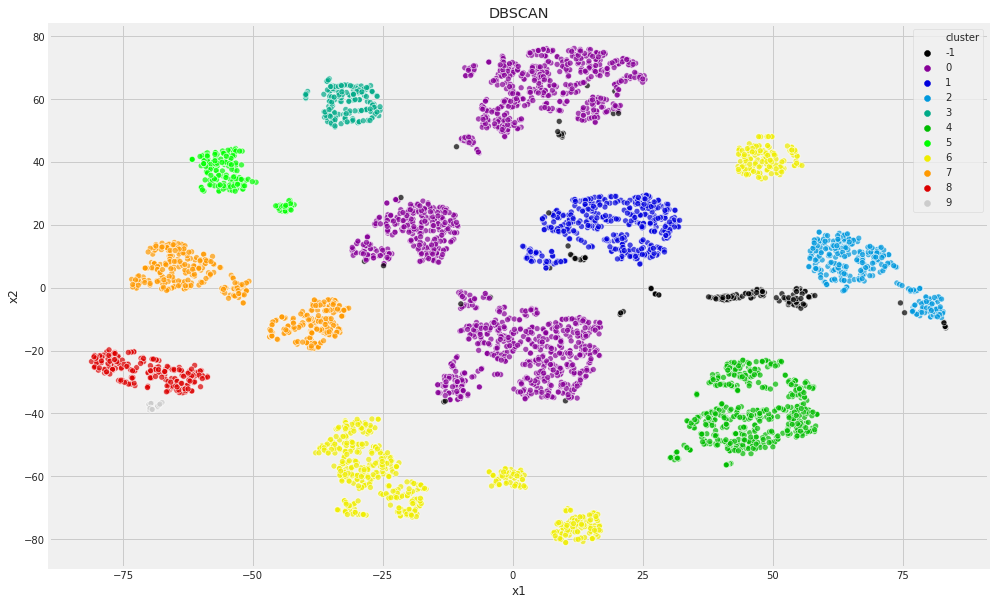

In [152]:
X = home.copy()
Xtsne = TSNE(n_components=2).fit_transform(X)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = clustering.labels_
dftsne.columns = ['x1','x2','cluster']

fig = plt.figure(figsize=(15,10))
plt.title('DBSCAN')
sns.scatterplot(data=dftsne,x='x1', y='x2', hue='cluster',
                legend="full", alpha=0.7, palette="nipy_spectral");